# Laboratorio 6 - Transformer encoder

Nombre: Polo Orellana Brayan Simon
Enlace a Github: https://github.com/bspoloo/SIS421-022025/tree/main/Laboratorios/Laboratorio%206

En este laboratorio se aplico el `Transformer Encoder` para reconocimiento y clasificación de deschos solidos con 5 clases de objetos.

## 1.- Importacion de librerias

In [77]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import numpy as np
import math
import sys
import math

## 2.- Definicion de Hiperparametros

In [78]:
patch_size = (16, 16)      # Tamaño de cada patch (afecta n_embd)
img_size = (224, 224)      # Resolución de entrada (afecta seq_len)
batch_size = 64            # Tamaño del batch (afecta memoria)

n_embd = 3 * 16 * 16       # 768 - Dimensiones del embedding por patch
seq_len = 14 * 14          # 196 - Número total de patches
n_heads = 4*4              # Número de cabezas de atención
num_classes = 5            # Número de clases de tu dataset
dropout = 0.3              # Regularización para evitar overfitting

learning_rate = 1e-4       # Tasa de aprendizaje
weight_decay = 1e-4        # Regularización L2

max_epochs = 10            # Épocas máximas de entrenamiento

## 3.- Creacion de AttnDataset

Para esta parte del dataset se uso la carga floja que consta que las imágenes se cargan solo cuando se necesitan (__getitem__). 

Esto me ayudo a no poner todas las imagenes en un array de numpy y cargarlos todos a la memoria.

Lo que se hace es guardar todas las rutas de las imagenes y sus labes, ambos retornarlos en listas distintas.

In [79]:
class LazyAttnDataset(Dataset):
    def __init__(self, data_dir, patch_size=(16, 16), img_size=(224, 224)):
        self.files, self.labels = [], []
        self.patch_size = patch_size
        self.img_size = img_size
        
        for label, classname in enumerate(sorted(os.listdir(data_dir))):
            class_dir = os.path.join(data_dir, classname)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.files.append(os.path.join(class_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        img = Image.open(self.files[ix]).convert("RGB")
        img = img.resize(self.img_size)
        img = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255 # Normalizar a [0, 1] y cambiar a CxHxW
        
        C, H, W = img.shape
        hh, ww = self.patch_size
        
        # Verificar que las dimensiones sean divisibles
        assert H % hh == 0, f"Height {H} not divisible by patch height {hh}"
        assert W % ww == 0, f"Width {W} not divisible by patch width {ww}"
        
        patches = img.unfold(1, hh, hh).unfold(2, ww, ww) #divide la imagen en patches de tamaño hh x ww
        patches = patches.permute(1, 2, 0, 3, 4).contiguous() # [num_patches_h, num_patches_w, C, hh, ww] y almacenados en memoria contigua
        patches = patches.view(-1, C * hh * ww) # Aplanar a [num_patches, C*hh*ww]
        label = torch.tensor(self.labels[ix]).long() # Convertir label a tensor long
        
        return patches, label


In [80]:
from torch.utils.data import DataLoader

train_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\train", patch_size=patch_size, img_size=img_size)
val_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\val", patch_size=patch_size, img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Creamos un Iterador sobre el dataloader con ``iter(train_loader)`` y toma el siguiente batch del iterador, en este caso solamente el primero ``next()``

In [ ]:
# Tomar un batch
imgs, labels = next(iter(train_loader))  # imgs.shape = [batch_size, C, H, W]

print("Batch shape:", imgs.shape)  # e.g., [64, 3, 224, 224]

# Aplanar cada imagen del batch
imgs_flat = imgs.view(imgs.size(0), -1)
print("Batch aplanado:", imgs_flat.shape)  # e.g., [64, 150528]

# Mostrar la primera imagen
print("Primera imagen (tensor):")
print(imgs[0])  # shape [3, 224, 224]

print("#"*30)

# Primera imagen aplanada
print("Primera imagen aplanada:")
print(imgs_flat[0])  # shape [150528]


Batch shape: torch.Size([64, 196, 768])
Batch aplanado: torch.Size([64, 150528])
Primera imagen (tensor):
tensor([[0.4000, 0.4941, 0.5490,  ..., 0.2392, 0.2392, 0.2353],
        [0.3569, 0.3961, 0.3412,  ..., 0.1922, 0.1255, 0.0980],
        [0.5373, 0.5451, 0.5647,  ..., 0.2353, 0.2078, 0.2902],
        ...,
        [0.4000, 0.3373, 0.3294,  ..., 0.3804, 0.3412, 0.3176],
        [0.3922, 0.3882, 0.4039,  ..., 0.3020, 0.3137, 0.2980],
        [0.3686, 0.3765, 0.3686,  ..., 0.2706, 0.2745, 0.2706]])
##############################
Primera imagen aplanada:
tensor([0.4000, 0.4941, 0.5490,  ..., 0.2706, 0.2745, 0.2706])


## 4.- Creacion del Modulo

Para esta clase heradada de **pl.LightningDataModule**, nos ayuda a organizar y automatizar la carga de datos para entrenamiento y validación en PyTorch Lightning.

In [82]:
class DesechosDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16, patch_size=(16, 16), img_size=(224, 224)):
        super().__init__()
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.img_size = img_size

    def setup(self, stage=None):
        self.train_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\train",
            patch_size=self.patch_size,
            img_size=self.img_size
        )
        self.val_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\val",
            patch_size=self.patch_size,
            img_size=self.img_size
        )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [83]:
imgsprueba = torch.rand(3,224,224)
print(imgsprueba.shape)

torch.Size([3, 224, 224])


In [84]:
#Creamos una imagen de prueba random
imgsprueba = torch.rand(3,224,224)  # RGB
C, H, W = imgsprueba.shape

#Definimos el tamaño de los patches
hh, ww = 16, 16

#Divide la imagen en patches no superpuestos de tamaño (hh, ww)
patches = imgsprueba.unfold(1, hh, hh).unfold(2, ww, ww)  # (C, 14, 14, 16, 16)
print(patches.shape)

#Reorganiza los parches para tenerlos en la forma (14, 14, C, 16, 16)
patches = patches.permute(1, 2, 0, 3, 4).contiguous()      # (14, 14, C, 16, 16)
print(patches.shape)

#Aplana cada parche a un vector de tamaño C*hh*ww
patches_flat = patches.view(-1, C*hh*ww) # (196, 768) (n_patches, patch_size)
print(patches_flat.shape)


torch.Size([3, 14, 14, 16, 16])
torch.Size([14, 14, 3, 16, 16])
torch.Size([196, 768])


## 5.- Vizualizacion de setup y patches de la imagen

In [85]:
#creamos el datamodule
attn_dm = DesechosDataModule(batch_size=batch_size, patch_size=patch_size, img_size=img_size)

#Configuramos el datamodule usando internamente el AttnDataset
attn_dm.setup()

In [ ]:
#Probamos el dataloader

imgs, labels = next(iter(attn_dm.train_dataloader())) #obtenemos un batch

#Comprobamos las dimensiones
imgs.shape, # [batch_size, num_patches, patch_dim]
labels.shape # [16]

torch.Size([64])

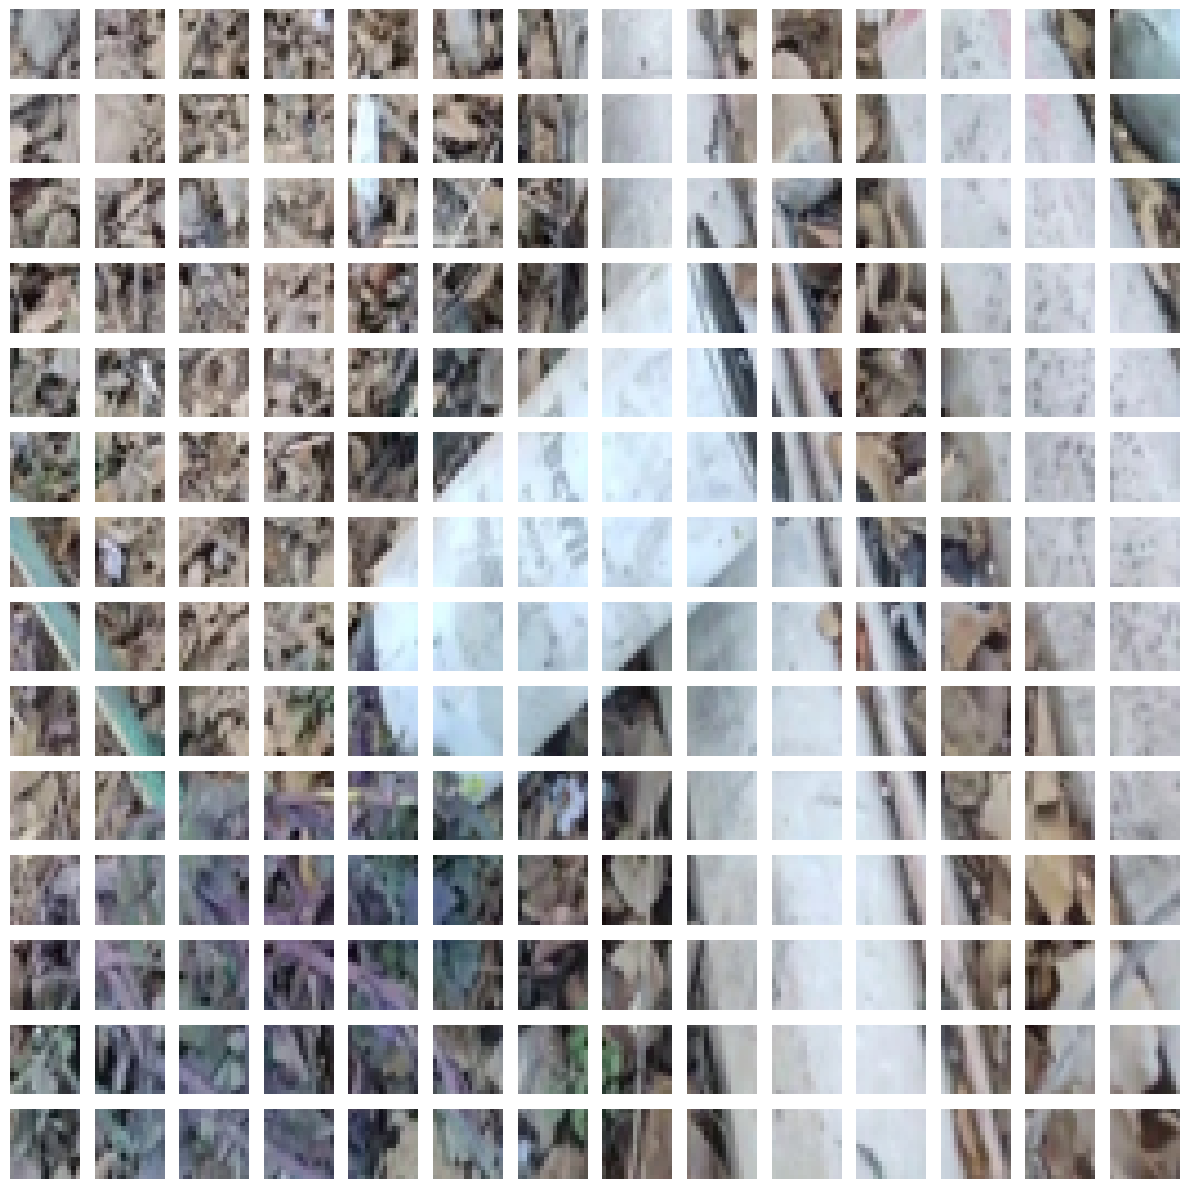

In [137]:
import matplotlib.pyplot as plt

# Tomamos un batch
patches_batch, labels = next(iter(attn_dm.train_dataloader()))  # (B, num_patches, C*hh*ww)
hh, ww = 16, 16 
C = 3

# Primer ejemplo del batch
patches = patches_batch[0]  # (196, 768)

# Grid de todos los patches
fig = plt.figure(figsize=(12,12))
for i in range(14):
    for j in range(14):
        idx = i*14 + j
        patch_flat = patches[idx]            # (768,)
        patch = patch_flat.view(C, hh, ww)   # (3,16,16)
        patch = patch.permute(1, 2, 0)       # (16,16,3)
        ax = plt.subplot(14, 14, idx+1)
        ax.imshow(patch.numpy())
        ax.axis('off')

plt.tight_layout()
plt.show()


## 6.- Clase Multihead Attention

Esta clase implementa el mecanismo de **Multi Head Attention**, la cual es la base para los transformers. 

Su función principal es permitir que cada parte (patch) de una secuencia (por ejemplo, una imagen dividida en patches) pueda "atender" o enfocarse en todas las demás partes al mismo tiempo, aprendiendo relaciones internas entre ellas.

* Calcula varias "atenciones" (cabezas) en paralelo, cada una con diferentes parámetros. Así, cada cabeza puede aprender diferentes tipos de relaciones o patrones entre los patches.

* Luego, combina (concatena y proyecta) la información de todas las cabezas para obtener una representación más rica y global de la secuencia.

Incialmente se definia una capa lineal para Q, K y V:

self.key = nn.Linear(n_embd, n_embd * n_heads)    # 768 → 768*16 = 12,288
self.query = nn.Linear(n_embd, n_embd * n_heads)  # 768 → 12,288  
self.value = nn.Linear(n_embd, n_embd * n_heads)  # 768 → 12,288
self.proj = nn.Linear(n_embd * n_heads, n_embd)   # 12,288 → 768

self.qkv = nn.Linear(n_embd, 3 * n_embd)  # 768 → 2,304 (3*768)
self.proj = nn.Linear(n_embd, n_embd)      # 768 → 768

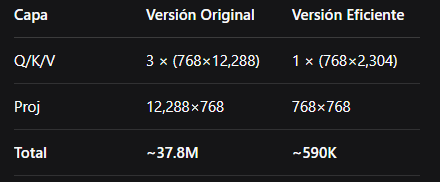


* Original: 37.8 millones de parámetros por capa de atención

* Eficiente: 590 mil parámetros por capa de atención

Donde Multihead attention esta definido como:

``MultiHead(Q, K, V) = Concat(head₁, head₂, ..., head_h)Wᵒ``

donde **head_i** = Attention(QW_iᵠ, KW_iᵏ, VW_iᵛ)

Cada cabeza debe tener dimensión **d_k** = d_model / h

In [ ]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads #d_k es la dimensión por cabeza
        
        assert n_embd % n_heads == 0, "n_embd must be divisible by n_heads"
        
        # QKV combinado
        self.qkv = nn.Linear(n_embd, 3 * n_embd)  # Solo 1 capa lineal
        self.proj = nn.Linear(n_embd, n_embd)
        
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)
        
        # Escalamiento para estabilizar los gradientes
        self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x):
        B, L, C = x.size()
        
        # QKV combinado - mucho más eficiente
        
        #Estructura: [batch, seq_len, QKV, num_heads, head_dim]
        #[QKV, batch, num_heads, seq_len, head_dim]
        qkv = self.qkv(x).reshape(B, L, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        
        #acceso a Q, K, V
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, nh, L, hd)
        
        # Atención escalada
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        # Aplicar atención
        y = attn @ v  # (B, nh, L, hd)
        y = y.transpose(1, 2).reshape(B, L, C)  # Reensamblar
        
        return self.proj_dropout(self.proj(y))


## 7.- Bloque transformer encoder

Esta clase implementa un bloque básico del encoder de un Transformer. 

Su función es procesar una secuencia de vectores (por ejemplo, los patches de una imagen) y permitir que cada elemento de la secuencia aprenda de todos los demás, combinando atención y una red neuronal simple (MLP).

In [89]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        
        # capa secuencial MLP
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )
        self.dropout = torch.nn.Dropout(dropout) # Regularización

    def forward(self, x):
        x_attn = self.attn(x) # aplicamos multihead attention
        x = self.ln1(x + self.dropout(x_attn)) # residual + normalization
        
        x_mlp = self.mlp(x) # aplicamos MLP
        x = self.ln2(x + self.dropout(x_mlp)) # residual + mlp

        return x

## 8.- Creacion del Modelo
Este modelo completo basado en Transformer para clasificación de imágenes usando PyTorch Lightning. Esto es lo que hace cada parte

* Capa lineal apra input embedding
* Capa lineal para el posicional embedding
* Capa de bloques sequential, un bloque por cada numero de capas, para procesamiento de secuencia de patches
* Capa final que toma todos los embeddings de los patches y predice la clase de imagen

En el forward aplicamos la, es la fusión de información visual y espacial: 
que es la fusión del contenido visual con el positional encoding.


**pos_embedding.-**
Es un mapa de vectores donde cada vector representa una posición física específica en la imagen.

* Inicio: Todos los embeddings empiezan en cero

* Aprendizaje: Durante el entrenamiento, el optimizer ajustará estos valores

* Resultado final: Cada posición tendrá un vector único aprendido

In [90]:
class EnhancedAttentionModel(pl.LightningModule):
    def __init__(self, n_input=768, n_embd=768, seq_len=196, n_heads=16, n_layers=2, num_classes=5, dropout=0.3):
        super().__init__()
        self.save_hyperparameters()
        
        self.mlp = None
        self.inp_embedding = nn.Linear(n_input, n_embd) # Capa de embedding
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, n_embd)) # Embedding posicional
        
        #capas transformer
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)]
        )

        # Clasificador final
        self.fc = nn.Linear(n_embd*seq_len, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        e = self.inp_embedding(x) + self.pos_embedding[:, :x.size(1), :] # Asegurar que el tamaño de secuencia coincida
        
        x = self.transformer_blocks(e)
        
        # Convierte a un tensor de forma (batch_size, n_embd*seq_len)
        y = self.fc(x.view(x.size(0), -1)) # Aplanar y clasificar - fully connected
        return y
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), 
            lr=learning_rate,
            weight_decay=weight_decay
        )

In [91]:
C = 3  # RGB

n_embd = C * patch_size[0] * patch_size[1]  # 3 * 16 * 16 = 768
seq_len = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])  # 14 * 14 = 196

print(f"Calculated dimensions:")
print(f"n_embd: {n_embd}")
print(f"seq_len: {seq_len}")
print(f"MLP input: {n_embd * seq_len}")  # 768 * 196 = 150528

Calculated dimensions:
n_embd: 768
seq_len: 196
MLP input: 150528


In [126]:
# Borra cachés y libera memoria
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

0

## 9.- Entrenamiento del modelo

In [94]:
attn_dm = DesechosDataModule(
    batch_size=batch_size,
    patch_size=patch_size,
    img_size=img_size
)
attn_dm.setup()

model = EnhancedAttentionModel(
    n_embd=n_embd,
    seq_len=seq_len,
    n_heads=n_heads,
    num_classes=num_classes,
    dropout=dropout
)

trainer = pl.Trainer(
    max_epochs=max_epochs,  # Más épocas para mejor convergencia
    precision=16 if torch.cuda.is_available() else 32,
    accumulate_grad_batches=2,
    gradient_clip_val=1.0,
    enable_progress_bar=True,
    enable_model_summary=True,
    deterministic=True
)

trainer.fit(model, attn_dm)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | inp_embedding      | Linear           | 590 K  | train
1 | transformer_blocks | Sequential       | 14.2 M | train
2 | fc                 | Linear           | 752 K  | train
3 | criterion          | CrossEntropyLoss | 0      | train
  | other params       | n/a              | 150 K  | n/a  
----------------------------------------------------------------
15.7 M    Trainable params
0         Non-trainable params
15.7 M    Total params
62.678    Total estimated m

Epoch 9: 100%|██████████| 626/626 [07:25<00:00,  1.40it/s, v_num=13, train_loss=1.59e-7, train_acc=1.000, val_loss=0.0301, val_acc=0.993] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 626/626 [07:26<00:00,  1.40it/s, v_num=13, train_loss=1.59e-7, train_acc=1.000, val_loss=0.0301, val_acc=0.993]


In [95]:
import torch

def save_model_with_metadata(model, trainer, config, save_path="model_with_metadata.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': trainer.optimizers[0].state_dict(),
        'hyperparameters': config,
        'epoch': trainer.current_epoch,
        'val_acc': trainer.callback_metrics.get('val_acc', 0.0),
        'val_loss': trainer.callback_metrics.get('val_loss', 0.0)
    }
    
    torch.save(checkpoint, save_path)
    print(f"Modelo con metadata guardado como: {save_path}")
    return save_path


In [96]:
# import sys
# import os

# # sys.path.append(os.path.abspath("."))
# # from functions.save_model import save_model_with_metadata

save_path = "desechos_model_4.pth"
config = {
    'patch_size': patch_size,
    'img_size': img_size,
    'n_embd': n_embd,
    'seq_len': seq_len,
    'num_classes': 5,
    'batch_size': batch_size,
    'max_epochs': max_epochs
}

metadata_path = save_model_with_metadata(model, trainer, config, save_path=save_path)

Modelo con metadata guardado como: desechos_model_4.pth


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from turtle import pd  # Esto parece un error, lo quito

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_from_dataframe(data):
    """Generar gráficas desde un DataFrame con los datos, incluyendo validation"""
    
    # Convertir a DataFrame si es una lista de strings
    if isinstance(data, list):
        # Parsear los datos
        rows = []
        for line in data:
            if line.strip():
                parts = line.split(',')
                if len(parts) >= 5:
                    row_data = {
                        'epoch': float(parts[0]),
                        'step': float(parts[1]),
                        'train_acc': float(parts[2]) if parts[2] else None,
                        'train_loss': float(parts[3]) if parts[3] else None
                    }
                    # Añadir validation metrics si existen
                    if len(parts) > 4 and parts[4].strip():
                        row_data['val_acc'] = float(parts[4])
                    if len(parts) > 5 and parts[5].strip():
                        row_data['val_loss'] = float(parts[5])
                    rows.append(row_data)
        df = pd.DataFrame(rows)
    else:
        df = data
    
    # Verificar si hay datos de validation
    has_validation = 'val_acc' in df.columns and not df['val_acc'].isna().all()
    
    # Crear gráficas - ahora 3x2 para incluir validation
    if has_validation:
        fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(18, 10))
        axes = np.vstack([axes, [None, None]])  # Añadir fila vacía para mantener estructura
    
    # Gráfica 1: Train Accuracy por step
    axes[0, 0].plot(df['step'], df['train_acc'], 'o-', markersize=3, linewidth=1, alpha=0.7, label='Train')
    if has_validation:
        axes[0, 0].plot(df['step'], df['val_acc'], 'o-', markersize=3, linewidth=1, alpha=0.7, label='Validation')
    axes[0, 0].set_title('Accuracy por Step')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfica 2: Train Loss por step
    axes[0, 1].plot(df['step'], df['train_loss'], 'o-', color='red', markersize=3, linewidth=1, alpha=0.7, label='Train')
    if has_validation:
        axes[0, 1].plot(df['step'], df['val_loss'], 'o-', color='blue', markersize=3, linewidth=1, alpha=0.7, label='Validation')
    axes[0, 1].set_title('Loss por Step')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gráfica 3: Train vs Validation Accuracy por epoch
    epoch_metrics = df.groupby('epoch').agg({
        'train_acc': 'mean',
        'train_loss': 'mean'
    }).reset_index()
    
    if has_validation:
        val_epoch_metrics = df.groupby('epoch').agg({
            'val_acc': 'mean',
            'val_loss': 'mean'
        }).reset_index()
    
    axes[1, 0].plot(epoch_metrics['epoch'], epoch_metrics['train_acc'], 'o-', label='Train Accuracy', linewidth=2, markersize=6)
    if has_validation:
        axes[1, 0].plot(val_epoch_metrics['epoch'], val_epoch_metrics['val_acc'], 'o-', label='Validation Accuracy', linewidth=2, markersize=6)
    axes[1, 0].set_title('Accuracy: Train vs Validation por Época')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Gráfica 4: Train vs Validation Loss por epoch
    axes[1, 1].plot(epoch_metrics['epoch'], epoch_metrics['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=6, color='red')
    if has_validation:
        axes[1, 1].plot(val_epoch_metrics['epoch'], val_epoch_metrics['val_loss'], 'o-', label='Validation Loss', linewidth=2, markersize=6, color='blue')
    axes[1, 1].set_title('Loss: Train vs Validation por Época')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    
    
    plt.tight_layout()
    plt.savefig('complete_training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mostrar estadísticas completas
    print("📊 ESTADÍSTICAS COMPLETAS DE ENTRENAMIENTO:")
    print(f"   • Train Accuracy: {df['train_acc'].mean():.3f} ± {df['train_acc'].std():.3f}")
    print(f"   • Train Loss: {df['train_loss'].mean():.3f} ± {df['train_loss'].std():.3f}")
    
    if has_validation:
        print(f"   • Validation Accuracy: {df['val_acc'].mean():.3f} ± {df['val_acc'].std():.3f}")
        print(f"   • Validation Loss: {df['val_loss'].mean():.3f} ± {df['val_loss'].std():.3f}")
        print(f"   • Best Validation Accuracy: {df['val_acc'].max():.3f}")
    
    print(f"   • Best Train Accuracy: {df['train_acc'].max():.3f}")
    print(f"   • Best Train Loss: {df['train_loss'].min():.3f}")
    
    return df

In [98]:
def load_and_preprocess_image(image_path, patch_size=(16, 16), img_size=(224, 224)):
    """
    Carga y preprocesa una imagen individual para el modelo de atención
    """
    # Cargar imagen
    img = Image.open(image_path).convert("RGB")
    
    # Redimensionar
    img = img.resize(img_size)

    # Convertir a tensor y normalizar [C, H, W]
    img_tensor = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255
    
    # Extraer patches (igual que en el dataset)
    C, H, W = img_tensor.shape
    hh, ww = patch_size
    
    patches = img_tensor.unfold(1, hh, hh).unfold(2, ww, ww)
    patches = patches.permute(1, 2, 0, 3, 4).contiguous()
    patches = patches.view(-1, C * hh * ww)
    
    # Añadir dimensión de batch
    patches = patches.unsqueeze(0)  # (1, num_patches, C*hh*ww)
    
    return patches, img_tensor

In [99]:
def predict_single_image(model, image_path, patch_size=(16, 16), img_size=(224, 224)):
    # Cargar y preprocesar imagen
    patches, original_img = load_and_preprocess_image(image_path, patch_size, img_size)
    
    # Mover al dispositivo del modelo
    device = next(model.parameters()).device
    patches = patches.to(device)
    
    # Predecir
    with torch.no_grad():
        model.eval()
        pred = model(patches)
        pred_class = pred.argmax(dim=1).item()
        pred_probs = F.softmax(pred, dim=1)[0]  # Probabilidades
    
    return pred_class, pred_probs, original_img, patches

In [113]:
def visualize_prediction(image_path, model, class_names=None):
    # Hacer predicción
    pred_class, pred_probs, original_img, patches = predict_single_image(model, image_path)
    
    # Obtener nombres de clases (si están disponibles)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(5)]
    
    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Mostrar imagen original
    axes[0].imshow(original_img.permute(1, 2, 0).numpy())
    axes[0].set_title('Imagen Original', fontsize=14)
    axes[0].axis('off')
    
    # Mostrar probabilidades
    axes[1].barh(class_names, pred_probs.cpu().numpy())
    axes[1].set_xlabel('Probabilidad', fontsize=12)
    axes[1].set_title(f'Predicción: {class_names[pred_class]}', fontsize=14)
    axes[1].set_xlim(0, 1)
    
    # Añadir valores de probabilidad
    for i, prob in enumerate(pred_probs.cpu().numpy()):
        axes[1].text(prob + 0.01, i, f'{prob:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, pred_probs


In [108]:
def visualize_patches_from_image(image_path, model, patch_size=(16, 16), class_names=None):
    """
    Visualiza todos los patches de una imagen
    """
    # Cargar imagen
    patches, original_img = load_and_preprocess_image(image_path, patch_size)
    
    # Mover al dispositivo del modelo
    device = next(model.parameters()).device
    patches = patches.to(device)
    
    # Predecir
    with torch.no_grad():
        model.eval()
        pred = model(patches)
        pred_class = pred.argmax(dim=1).item()
    
    # Parámetros
    C, hh, ww = 3, patch_size[0], patch_size[1]
    num_patches = patches.shape[1]
    grid_size = int(num_patches ** 0.5)  # 14 para 224x224 con patches 16x16
    
    # Crear figura
    fig = plt.figure(figsize=(12, 12))
    
    # Mostrar todos los patches
    for i in range(grid_size):
        for j in range(grid_size):
            patch_idx = i * grid_size + j
            patch_flat = patches[0, patch_idx]  # (C*hh*ww,)
            patch = patch_flat.view(C, hh, ww).permute(1, 2, 0).cpu().numpy()
            
            ax = plt.subplot(grid_size, grid_size, patch_idx + 1)
            ax.imshow(patch)
            ax.axis('off')
            # ax.set_title(f'{i},{j}', fontsize=6)  # Opcional: coordenadas
    
    fig.suptitle(f'Predicción: Clase {class_names[pred_class]}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [102]:
def load_model_complete(checkpoint_path, model_class=EnhancedAttentionModel):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    if 'hyperparameters' in checkpoint:
        config = checkpoint['hyperparameters']
        print("Cargando modelo con configuración:", config)
        
        model = model_class(
            n_embd=config['n_embd'],
            seq_len=config['seq_len'],
            num_classes=config['num_classes']
        )
        
        model.load_state_dict(checkpoint['model_state_dict'])
        
    else:
        model = torch.load(checkpoint_path)
    
    model.eval()
    print("Modelo cargado exitosamente!")
    return model

## 10.- Evaluacion del Modelo

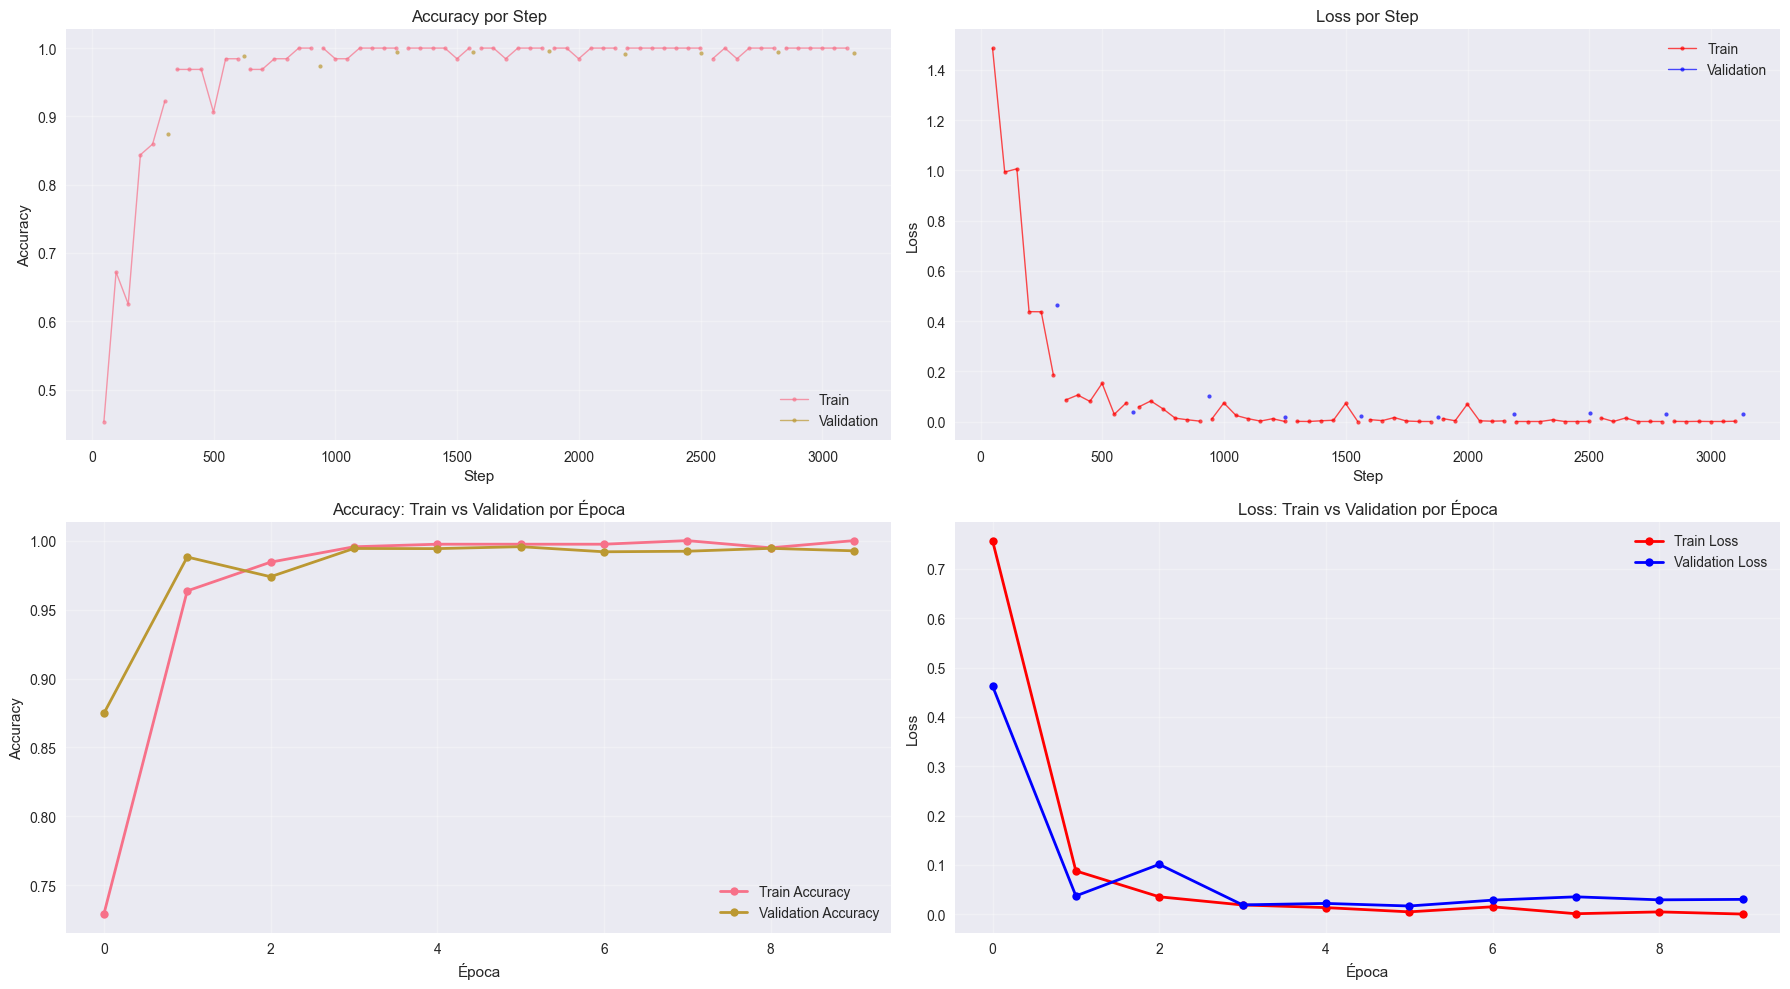

📊 ESTADÍSTICAS COMPLETAS DE ENTRENAMIENTO:
   • Train Accuracy: 0.967 ± 0.095
   • Train Loss: 0.091 ± 0.262
   • Validation Accuracy: 0.979 ± 0.037
   • Validation Loss: 0.078 ± 0.137
   • Best Validation Accuracy: 0.996
   • Best Train Accuracy: 1.000
   • Best Train Loss: 0.000


,epoch,step,train_acc,train_loss,val_acc,val_loss
0,0,49,0.453125,1.486467,NaN,NaN
1,0,99,0.671875,0.993049,NaN,NaN
2,0,149,0.625000,1.005914,NaN,NaN
3,0,199,0.843750,0.437362,NaN,NaN
4,0,249,0.859375,0.436809,NaN,NaN


In [119]:
import pandas as pd

df = pd.read_csv(r"D:\Ciencias\SIS421-022025\Laboratorios\Laboratorio 6\lightning_logs\version_13\metrics.csv", sep=",")

df = plot_from_dataframe(df)
df.head()

In [111]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

def create_confusion_matrix(model, dataloader, class_names):
    """
    Crea y muestra la matriz de confusión
    """
    device = next(model.parameters()).device
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculando matriz de confusión"):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Calcular matriz de confusión
    cm = confusion_matrix(all_targets, all_preds)
    
    # Mostrar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Mostrar reporte de clasificación
    print("\n" + "="*50)
    print("REPORTE DE CLASIFICACIÓN")
    print("="*50)
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    return cm, all_preds, all_targets

# Usar la función


Calculando matriz de confusión: 100%|██████████| 157/157 [04:04<00:00,  1.56s/it]


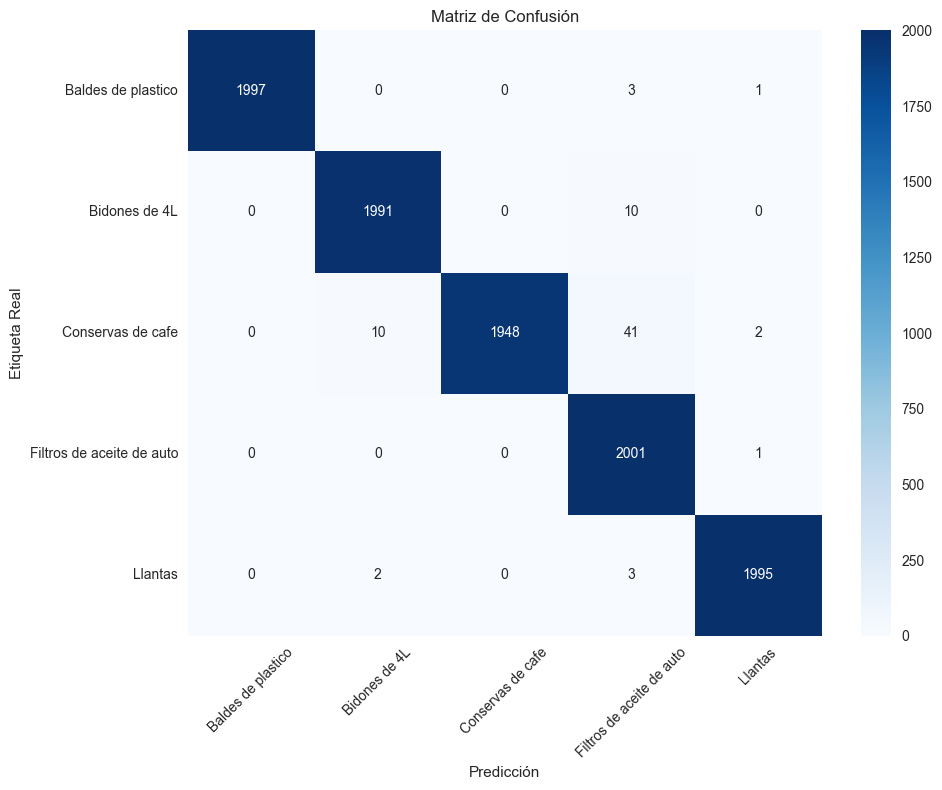


REPORTE DE CLASIFICACIÓN
                           precision    recall  f1-score   support

       Baldes de plastico       1.00      1.00      1.00      2001
            Bidones de 4L       0.99      1.00      0.99      2001
        Conservas de cafe       1.00      0.97      0.99      2001
Filtros de aceite de auto       0.97      1.00      0.99      2002
                  Llantas       1.00      1.00      1.00      2000

                 accuracy                           0.99     10005
                macro avg       0.99      0.99      0.99     10005
             weighted avg       0.99      0.99      0.99     10005



In [112]:
class_names = [
    'Baldes de plastico', 
    'Bidones de 4L', 
    'Conservas de cafe', 
    'Filtros de aceite de auto', 
    'Llantas'
]

cm, preds, targets = create_confusion_matrix(model, attn_dm.val_dataloader(), class_names)

## 11.- Prediccion

In [ ]:
image_path = r"D:\Ciencias\Dataset Residuos solidos\data\val\Filtros de aceite de auto\0xw7xs5eovwgpl2e.jpg"

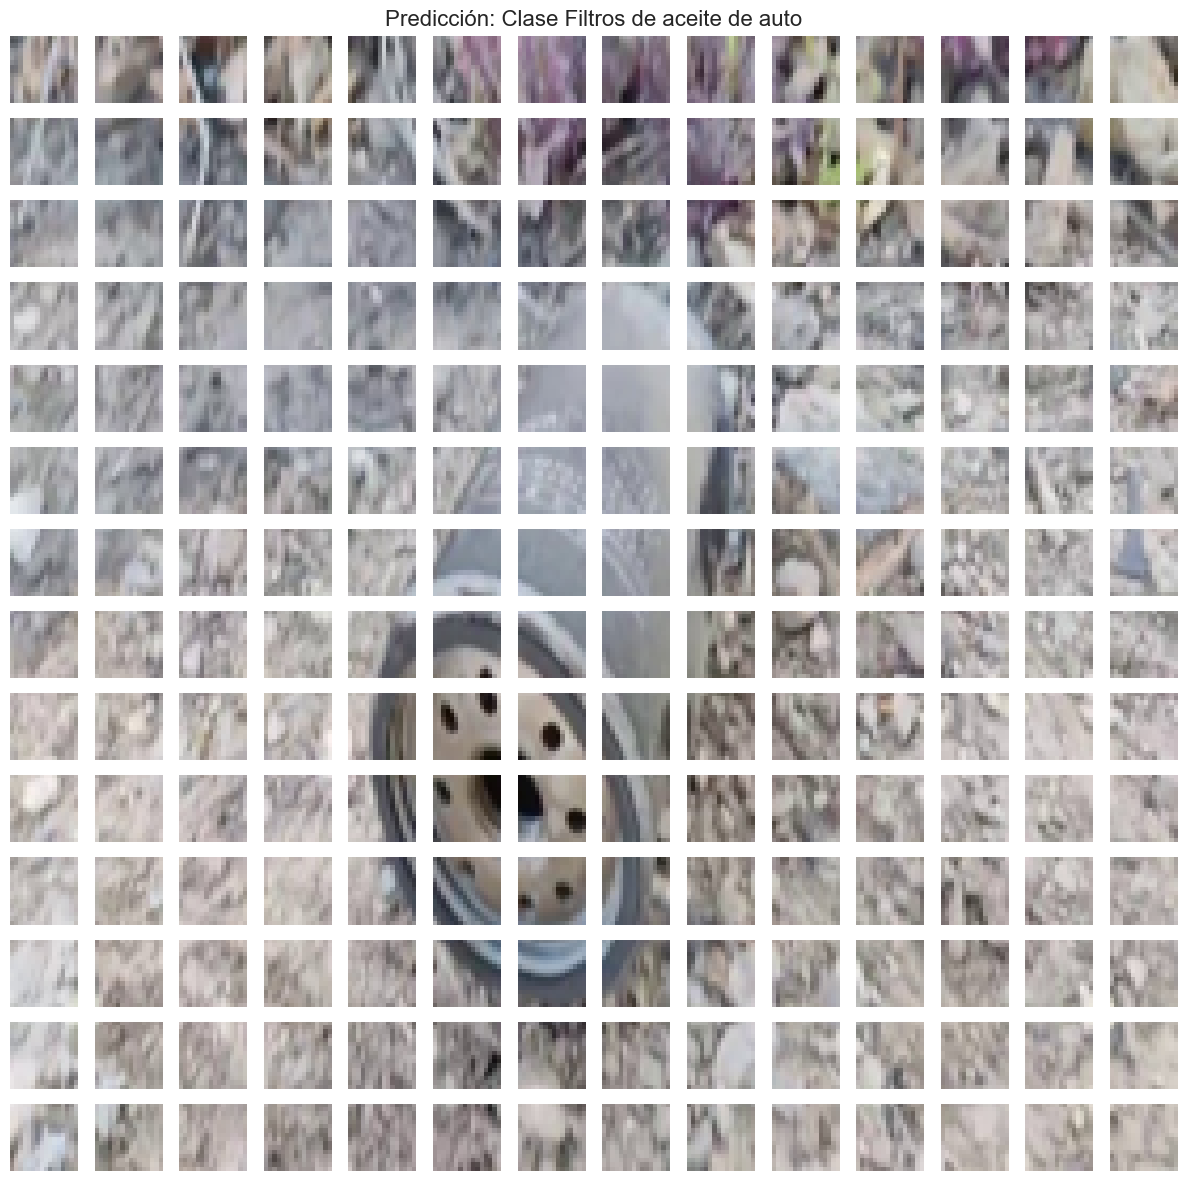

In [121]:
visualize_patches_from_image(image_path=image_path, model=model, patch_size=patch_size, class_names=class_names)

In [124]:

model = load_model_complete(metadata_path)

# visualize_patches_from_image(image_path=image_path, model=model, patch_size=patch_size, class_names=class_names)

Cargando modelo con configuración: {'patch_size': (16, 16), 'img_size': (224, 224), 'n_embd': 768, 'seq_len': 196, 'num_classes': 5, 'batch_size': 64, 'max_epochs': 10}
Modelo cargado exitosamente!


C:\Users\Animetx\AppData\Local\Temp\ipykernel_4916\728266544.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.